#### Sentiment Analysis

Sentiment analysis classifies a text as reflecting the positive or negative orientation (sentiment) that a writer expresses toward some object

In [1]:
import pandas as pd
import numpy as np

In [2]:
import nltk

nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from nltk.corpus import twitter_samples

In [4]:
positive_tweets = twitter_samples.strings('positive_tweets.json')

In [5]:
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [6]:
combined_tweets = positive_tweets + negative_tweets

In [7]:
combined_labels = np.append(np.ones(len(positive_tweets)), np.zeros(len(negative_tweets)))

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(combined_tweets, combined_labels, test_size=0.25, random_state=21, stratify=combined_labels)

In [10]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import string
import re

In [11]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # remove stock market tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        # remove stopwords and punctuation
        if (word not in stopwords_english and word not in string.punctuation):
            # stemming word
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

In [12]:
sample_tweet = X_train[0]

In [13]:
print(sample_tweet)

This pain just below my right rib cage, since yesterday :(


In [14]:
print(process_tweet(sample_tweet))

['pain', 'right', 'rib', 'cage', 'sinc', 'yesterday', ':(']


#### Naive Bayes

Naive Bayes is a generative model that makes the bag-of-words assumption (position doesn’t matter) and the conditional independence assumption (words are conditionally independent of each other given the class)

#### Training Naive Bayes Classifier

Naive Bayes is a probabilistic classifier, meaning that for a document $d$, out of all classes $c \in C$ the classifier returns the class $\widehat{c}$ which has the maximum posterior probability given the document

\begin{align}
\widehat{c} = \underset{c \: \in \: C}{\mathrm{argmax}} \: P(c \mid d)
\end{align}

The intuition of Bayesian classification is to use Bayes rule to transform the equation into other probabilities that have some useful properties

\begin{align}
\widehat{c} = \underset{c \: \in \: C}{\mathrm{argmax}} \: P(c \mid d) = \underset{c \: \in \: C}{\mathrm{argmax}} \: \frac{P(d \mid c) \: P(c)}{P(d)}
\end{align}

We can conveniently simplify the equation by dropping the denominator $P(d)$ because it must have the same probability for each class

\begin{align}
\widehat{c} = \underset{c \: \in \: C}{\mathrm{argmax}} \: \overbrace{P(d \mid c)}^{likelihood} \: \overbrace{P(c)}^{prior}
\end{align}

Without loss of generalization, we can represent a document $d$ as a set of features $w_1, w_2, \ldots, w_n$

\begin{align}
\widehat{c} = \underset{c \: \in \: C}{\mathrm{argmax}} \: P({w_1, w_2, \ldots, w_n} \mid c) \: P(c)
\end{align}

Naive Bayes classifiers therefore make two simplifying assumptions

1. **bag-of-words assumption** position doesn’t matter
2. **naive bayes assumption** probabilities $P(f_i|c)$ are independent and hence can be 'naively' multiplied

Naive Bayes calculations, like calculations for language modeling, are done in log space, to avoid underflow and increase speed

\begin{align}
\widehat{c} = \underset{c \: \in \: C}{\mathrm{argmax}} \: log(P(c)) + \sum{log(P(w_i \mid c))}
\end{align}

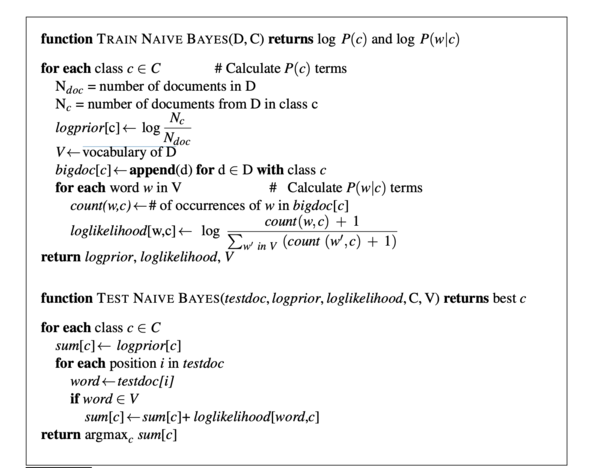

**Bag of Words**

An unordered set of words with their position ignored, keeping only their frequency in the document

In [15]:
def bag_of_words(tweets, labels):
  counts = {}
  for tweet, label in zip(tweets, labels):
    for word in process_tweet(tweet):
      pair = (word, label)
      counts[pair] = counts.get(pair, 0) + 1
  
  return counts

**Helper Functions**

In [19]:
def total_word_labels(label, freqs):
  total = 0
  for pair in freqs.keys():
    _word, _label = pair
    if _label == label:
      total += freqs[pair]
  return total

In [20]:
def train_naive_bayes(X_train, y_train):
  logprior = {}
  loglikelihood = {}
  total_wc = {}

  bigdocs = bag_of_words(X_train, y_train)
  V = {w for w, _ in bigdocs.keys()}
  C = set(y_train)
  
  for c in C:
    N_doc = len(X_train)
    N_c = np.sum(y_train == c)
    logprior[c] = np.log(N_c / N_doc)
    total_wc[c] = total_word_labels(c, bigdocs)

    for w in V:
      count_wc = bigdocs.get((w, c), 0)      
      loglikelihood[(w, c)] = np.log((count_wc + 1) / (total_wc[c] + len(V)))
  
  return logprior, loglikelihood, V

In [21]:
logprior, loglikelihood, V = train_naive_bayes(X_train, y_train)

In [22]:
def test_naive_bayes(X_test, y_test, logprior, loglikelihood, V):
  C = set(y_test)

  y_preds = []
  for tweet in X_test:
    sum = {}
    words = process_tweet(tweet)

    for c in C:
      sum[c] = logprior[c]
      for w in words:
        # skip unknown and stop words
        if w in V:
          sum[c] += loglikelihood[(w, c)]
    
    y_preds.append(max(sum, key=sum.get))

  return y_preds

#### Optimizing for Sentiment Analysis

1. For each document we remove all duplicate words before concatenating them into the single big document during training and we also remove duplicate words from test documents

2. prepend the prefix NOT to every word after a token of logical negation (n’t, not, no, never) until the next punctuation mark

#### Model Evaluation

In [23]:
from sklearn.metrics import accuracy_score, f1_score

In [24]:
y_preds = test_naive_bayes(X_test, y_test, logprior, loglikelihood, V)

In [25]:
scores = {'acc': accuracy_score(y_preds, y_test), 'f1': f1_score(y_preds, y_test)}

In [26]:
scores

{'acc': 0.9948, 'f1': 0.9948103792415169}

In [34]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1250
         1.0       0.99      1.00      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500

